In [2]:
import decode_eeg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot topomap

In [4]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [18]:
# Not actually used here, just needed to init wrangl and sync
time_window = 1
time_step = 2
trial_average = 1
n_splits = 3

group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict=group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2,experiment_name3],
                                    get_matched_data = False)

In [19]:
erps = np.empty((sync.nsub,clfr.num_labels,len(exp1.info['chan_labels']),len(wrangl.t)))
for isub,sub in enumerate(sync.all_ids):
    print(isub)
    xdata,ydata  = sync.load_eeg(sub)
    xdata,ydata = sync.group_data(xdata,ydata)
    for i,ss in enumerate(np.unique(ydata)):
        erps[isub,i] = np.mean(xdata[ydata==ss],0)

# average over every subject
grand_erps = np.mean(erps,0)        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [22]:
grand_erps.shape

(4, 30, 725)

In [95]:
time_idx = (wrangl.t>250) & (wrangl.t<500)
chan_locs = np.vstack([exp1.info['chan_x'],exp1.info['chan_y']]).T

ss_1 = np.mean(grand_erps[:,:,time_idx],2)[0]
ss_2 = np.mean(grand_erps[:,:,time_idx],2)[1]
ss_3 = np.mean(grand_erps[:,:,time_idx],2)[2]
ss_4 = np.mean(grand_erps[:,:,time_idx],2)[3]

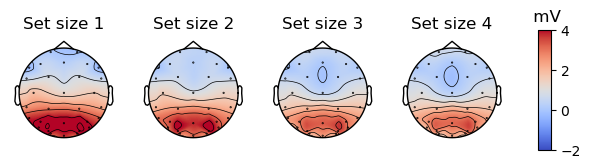

In [128]:
vmin = -2
vmax = 4
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
im,cm  = plot_topomap(ss_1, chan_locs/11, axes=ax1, show=False, res = 300, vmin=vmin, vmax=vmax, cmap='coolwarm')   
im,cm  = plot_topomap(ss_2, chan_locs/11, axes=ax2, show=False, res = 300, vmin=vmin, vmax=vmax, cmap='coolwarm')   
im,cm  = plot_topomap(ss_3, chan_locs/11, axes=ax3, show=False, res = 300, vmin=vmin, vmax=vmax, cmap='coolwarm')   
im,cm  = plot_topomap(ss_4, chan_locs/11, axes=ax4, show=False, res = 300, vmin=vmin, vmax=vmax, cmap='coolwarm')   

ax1.set_title('Set size 1')
ax2.set_title('Set size 2')
ax3.set_title('Set size 3')
ax4.set_title('Set size 4')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.02
ax_y_start = 0.4
ax_y_height = 0.25
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(' mV') # title on top of colorbar
plt.savefig('topo.png',dpi=500,bbox='tight')
plt.show()

# Plot classifier coefficient weights 

In [ ]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 3

group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict=group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2,experiment_name3],
                                    get_matched_data = False)

clfr = decode_eeg.Classification(wrangl,sync.nsub)

In [25]:
coefs = np.empty((sync.nsub,wrangl.n_splits,len(wrangl.t),len(exp1.info['chan_labels'])))

for isub,sub in enumerate(sync.all_ids):
    print(isub)

    xdata,ydata  = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata,ydata = sync.group_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
            coefs[isub,wrangl.ifold,wrangl.itime,:] = clfr.classifier.coef_

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [30]:
interp = decode_eeg.Interpreter(clfr, subtitle = f'all_unique_subs_{trial_average}_')
# interp.save_results()
# interp.load_results()

In [62]:
time_idx = (wrangl.t>250) & (wrangl.t<800)
coefs_nsw = np.mean(np.mean(np.mean(coefs,0),0)[time_idx],0)
chan_locs = np.vstack([exp1.info['chan_x'],exp1.info['chan_y']]).T

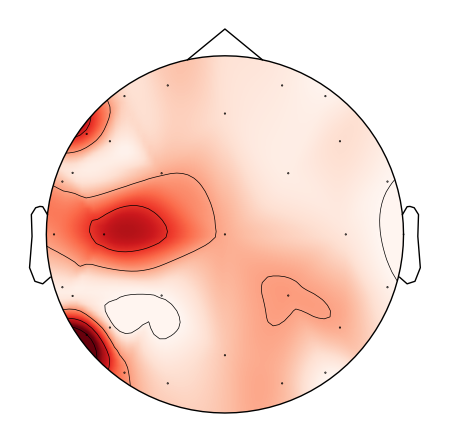

(<matplotlib.image.AxesImage at 0x258164c1a90>,
 <matplotlib.contour.QuadContourSet at 0x258164e0220>)

In [71]:
plot_topomap(abs(coefs_nsw),chan_locs/11)